[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# Multiple Schemas

## Review

We just covered state schema and reducers.

Typically, all graph nodes communicate with a single schema.

Also, this single schema contains the graph's input and output keys / channels.

## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

✅ Graph successfully built with customized schemas and logic.


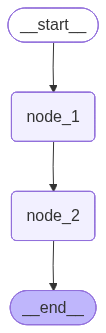

In [6]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define the overall schema shared between graph nodes
class OverallState(TypedDict):
    foo: int
    status: str  # Added to show how the graph can hold additional non-essential info

# Define private schema (used internally)
class PrivateState(TypedDict):
    baz: int

# Node 1: Processes input and generates an internal private value
def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    baz_value = state["foo"] * 2   # Modified logic: multiply instead of add
    print(f"Internal (private) value computed: baz = {baz_value}")
    return {"baz": baz_value}

# Node 2: Consumes private value and updates main state
def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    foo_value = state["baz"] - 1   # Slightly different transformation
    print(f"Output (public) value computed: foo = {foo_value}")
    return {"foo": foo_value, "status": "processed"}  # Adds an extra key for output schema

# Build graph with OverallState as the base schema
builder = StateGraph(OverallState)

# Register nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Define graph flow
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Compile and visualize the graph
graph = builder.compile()

print("✅ Graph successfully built with customized schemas and logic.")
display(Image(graph.get_graph().draw_mermaid_png()))


In [3]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema.

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

✅ Custom conversational graph built successfully.


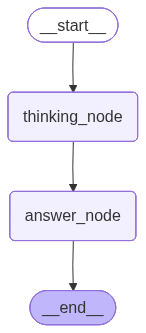

In [7]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define schema for overall conversation state
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str
    confidence: float  # Added new field to hold confidence level of the answer

# Node 1: Think through the question and generate notes
def thinking_node(state: OverallState):
    print("---Thinking Node---")
    thought = f"Analyzing the question: '{state['question']}'"
    print(thought)
    # Simulate reasoning and generate internal notes
    return {
        "notes": f"{thought} ... possible clue: Lance is involved.",
        "answer": "",
        "confidence": 0.6  # intermediate confidence
    }

# Node 2: Use notes to produce the final answer
def answer_node(state: OverallState):
    print("---Answer Node---")
    if "Lance" in state["notes"]:
        final_answer = "Goodbye Lance"
        confidence = 0.95
    else:
        final_answer = "Not enough context"
        confidence = 0.3
    print(f"Final Answer: {final_answer} (Confidence: {confidence})")
    return {"answer": final_answer, "confidence": confidence, "notes": state["notes"]}

# Build the graph
graph = StateGraph(OverallState)
graph.add_node("thinking_node", thinking_node)
graph.add_node("answer_node", answer_node)

# Define edges
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

# Compile and visualize
graph = graph.compile()
print("✅ Custom conversational graph built successfully.")
display(Image(graph.get_graph().draw_mermaid_png()))


Notice that the output of invoke contains all keys in `OverallState`.

In [8]:
graph.invoke({"question":"why"})

---Thinking Node---
Analyzing the question: 'why'
---Answer Node---
Final Answer: Goodbye Lance (Confidence: 0.95)


{'question': 'why',
 'answer': 'Goodbye Lance',
 'notes': "Analyzing the question: 'why' ... possible clue: Lance is involved.",
 'confidence': 0.95}

Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph.

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`.

✅ Graph compiled successfully with custom schemas.


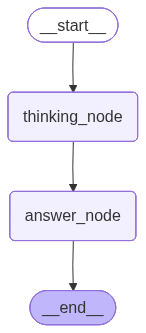

---Thinking Node---
---Answer Node---

Graph Output:
{'answer': 'Final Answer: Processing your question thoughtfully... (based on internal notes)', 'summary': 'Reasoned through 1 step(s).'}


In [9]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define separate schemas for input, output, and overall processing
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str
    summary: str  # Added to demonstrate richer output schema

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str
    reasoning_steps: int  # Added to show internal tracking between nodes

# Node 1: Think about the question and generate intermediate notes
def thinking_node(state: InputState):
    print("---Thinking Node---")
    question_text = state["question"].strip().lower()
    if "bye" in question_text:
        response = "Seems like you’re saying goodbye."
    else:
        response = "Processing your question thoughtfully..."
    notes = f"Identified intent from question: '{question_text}'."
    return {"answer": response, "notes": notes, "reasoning_steps": 1}

# Node 2: Produce a final answer and a summary for output
def answer_node(state: OverallState) -> OutputState:
    print("---Answer Node---")
    final_answer = f"Final Answer: {state['answer']} (based on internal notes)"
    summary = f"Reasoned through {state['reasoning_steps']} step(s)."
    return {"answer": final_answer, "summary": summary}

# Build graph that uses different schemas for input/output
graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# Add nodes
graph.add_node("thinking_node", thinking_node)
graph.add_node("answer_node", answer_node)

# Define edges
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

# Compile and visualize
graph = graph.compile()
print("✅ Graph compiled successfully with custom schemas.")
display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke graph with a custom input
result = graph.invoke({"question": "Hi there"})
print("\nGraph Output:")
print(result)


We can see the `output` schema constrains the output to only the `answer` key.